# k-Armed Bandit Algorithms


In this notebook, you will implement some of the k-Armed Bandit algorithms described in [Sutton and Barto's book, Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html). A class ```kArmedBandit``` that  can represent k-armed bandit problems and the uniform k-armed bandit algorithm are already implemented. See the code for those and examples below, and add your implementation of other algorithms at the end of the notebook.

### Install dependendices

In [93]:
# # pip install numpy matplotlib

### Imports

In [94]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Setting the random seed allows for replication of results of experiments that
# rely on np.random:
np.random.seed(1234)

### The ```kArmedBandit``` class

An instance of a ```kArmedBandit``` class represents one instance of a k-armed bandit problem. A problem is represented by $k$ arms where each arm is defined by the mean and variance of its payout. Each instance of the class keeps track of mean reward, history of plays, how many times each arm has been played and so forth.

The histories (of plays, rewards, and mean rewards) grow by one item each time a new play is made.

In [95]:
class kArmedBandit:
    """
    Represent an instance of a k-armed bandit problem
    """

    def __init__(self, means, variances):
        """
        Create an instance with means and variances for the bandit's arms.
        """
        assert len(means) == len(
            variances
        ), f"Length of means ({len(means)}) and variances ({len(variances)}) must match"

        self.true_means = means
        self.true_variances = variances
        self.number_of_arms = len(means)

        # History of rewards received, one added each time an arm is played
        self.history_of_rewards = []
        # History of mean rewards received, one added each time an arm is played
        self.history_of_mean_rewards = []
        # History of arms played, one added each time an arm is played
        self.history_of_plays = []
        # Number of times each arm has been played
        self.number_of_plays = np.zeros(self.number_of_arms)
        # Accumulated reward for each arm
        self.accumulated_observed_rewards = np.zeros(self.number_of_arms)
        # Total reward observed
        self.total_reward = 0
        self.total_plays = 0

    def play(self, arm_number):
        """
        Play a given arm and return the payout/reward
        """

        # Sample reward from the arm's normal distribution
        reward = np.random.normal(
            self.true_means[arm_number], self.true_variances[arm_number]
        )

        # House keeping: record reward and current play in the lists and vars
        # necessary for plotting and making the implementation of algorithms easier
        self.history_of_rewards.append(reward)
        self.accumulated_observed_rewards[arm_number] += reward
        self.number_of_plays[arm_number] += 1
        self.history_of_plays.append(arm_number)
        self.total_reward += reward
        self.total_plays += 1
        self.history_of_mean_rewards.append(self.total_reward / (self.total_plays))

        return reward

    @property
    def observed_means(self):
        """
        Mean of observed rewards for each arm
        """
        # Convert lists to numpy arrays for element-wise operations
        accumulated_observed_rewards = np.array(self.accumulated_observed_rewards)
        number_of_plays = np.array(self.number_of_plays)

        # Replace zeros with ones in number_of_plays to avoid division by zero
        number_of_plays_with_no_zeros = np.where(
            number_of_plays == 0, 1, number_of_plays
        )

        # Element-wise division
        return accumulated_observed_rewards / number_of_plays_with_no_zeros

    @property
    def history_of_ideal_mean_rewards(self):
        """
        Get a history of ideal mean reward, that is, if the arm with the highest mean
        had always been played (useful when plotting results)
        """
        ideal = np.empty(self.total_plays)
        ideal.fill(np.max(self.true_means))
        return ideal

    def __len__(self):
        """
        Let the length of a k-armed bandit be k:
        """
        return self.number_of_arms

    def __str__(self):
        return "{self.number_of_arms} arms with true means: {self.true_means}, variances: {self.true_variances}".format(
            self=self
        )

    def generate_instance(number_of_arms, mean_low_limit, mean_high_limit, variance):
        """
        Class method for generating the means and variances for an instance.
        """
        means = (
            np.random.rand(number_of_arms) * (mean_high_limit - mean_low_limit)
            + mean_low_limit
        )
        variances = np.empty(number_of_arms)
        variances.fill(variance)
        return (means, variances)

### Uniform bandit algorithm

The uniform bandit algorithm is simple: try each arm $w$ times and play the arm that yieded the highest mean payout for the rest the episodes.

In [96]:
class UniformBanditAlgorithm:
    def __init__(self, k_armed_bandit, w):
        """Setup the algorithm"""
        self.k_armed_bandit = k_armed_bandit
        self.w = w
        self.best_arm = None
        # Calculate how many episodes will be used for exploration in the beginning
        self.exploration_episodes = self.w * len(self.k_armed_bandit)

    def run(self, episodes):
        """Run the algorithm for a given number of episodes"""
        assert (
            self.best_arm == None
        ), "You should not call run() twice on the same instance, instead create a new instance"
        assert (
            self.k_armed_bandit.total_plays == 0
        ), "You should run an algorithm on the same instance twice, instead create a new instance"
        assert (
            self.exploration_episodes <= episodes
        ), "Not enough episodes to try all bandits {self.w} times".format(self=self)

        # Play each arm w times
        for arm in range(0, len(self.k_armed_bandit)):
            for i in range(0, self.w):
                self.k_armed_bandit.play(arm)

        # Find the index of the arm that yielded the highest mean payout
        self.best_arm = np.argmax(self.k_armed_bandit.observed_means)

        # Play the best arm for the rest of the episodes
        for _ in range(self.w * len(self.k_armed_bandit), episodes):
            self.k_armed_bandit.play(self.best_arm)

### Test of the uniform bandit algorithm on one instance



In [97]:
# Generate an instance with 10 arms, means from [-1,1] and a variance of 1
means, variances = kArmedBandit.generate_instance(10, -1, 1, 3)
problem_instance = kArmedBandit(means, variances)

print(problem_instance)

10 arms with true means: [-0.6169611   0.24421754 -0.12454452  0.57071717  0.55995162 -0.45481479
 -0.44707149  0.60374436  0.91627871  0.75186527], variances: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


In [98]:
# Create a uniform bandit algorithm for the problem instance with w=20
uniform_bandit = UniformBanditAlgorithm(problem_instance, 20)

# Run the algorithm for 1000 episodes
uniform_bandit.run(1000)

# Check if the algorithm found the best arm
print(
    f"Estimated best arm: {uniform_bandit.best_arm}, "
    f"true best arm {np.argmax(problem_instance.true_means)}"
)

Estimated best arm: 3, true best arm 8


Note that the algorithm may not always find the best instance if, for instance, two means are close to one another or $w$ is too low.

### A plot of the results

[]

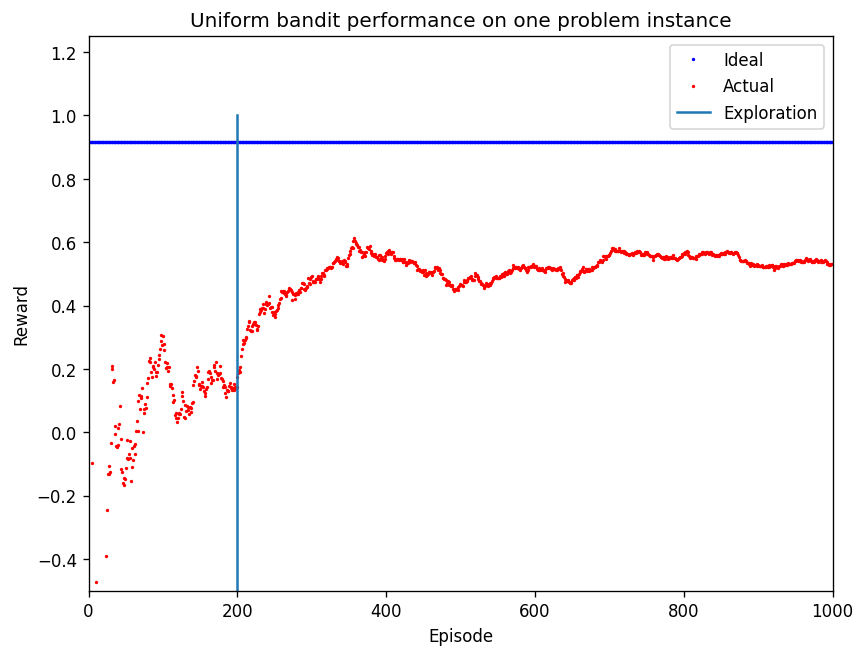

In [99]:
# Plot the results:
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, problem_instance.total_plays)

# Plot the ideal scenario when only the best arm is played vs. the actual:
p1 = ax.plot(problem_instance.history_of_ideal_mean_rewards, "bo", markersize=1)
p2 = ax.plot(problem_instance.history_of_mean_rewards, "ro", markersize=1)

# Plot a vertical line to indicate the cut-off between exploration
# and exploitation
ax.plot(
    [uniform_bandit.exploration_episodes, uniform_bandit.exploration_episodes],
    [-0.5, 1],
)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend(["Ideal", "Actual", "Exploration"])

plt.title("Uniform bandit performance on one problem instance")

plt.plot()

### Uniform bandit on multiple instances

To approximate the general performance of an algorithm, it is often necessary to run it on multiple problem instances. The code below runs the uniform bandit algorithm on `instances = 100` instances and plots the results.

In [100]:
# Config:
instances = 100
arms = 10
episodes = 1000
w = 25

# Accumulate results across instances data for plotting:
accumulated_history_of_mean_rewards_greedy = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_greedy = np.zeros(episodes)

uniform_bandit = None
times_best_arm_found = 0

# Create and run instances:
for i in range(0, instances):
    means, variances = kArmedBandit.generate_instance(arms, -1, 1, 1)
    instance = kArmedBandit(means, variances)
    uniform_bandit = UniformBanditAlgorithm(instance, w)
    uniform_bandit.run(episodes)

    accumulated_history_of_ideal_mean_rewards_greedy = (
        accumulated_history_of_ideal_mean_rewards_greedy
        + instance.history_of_ideal_mean_rewards
    )
    accumulated_history_of_mean_rewards_greedy = (
        accumulated_history_of_mean_rewards_greedy + instance.history_of_mean_rewards
    )

    if uniform_bandit.best_arm == np.argmax(instance.true_means):
        times_best_arm_found += 1

print(f"Times best arm found {times_best_arm_found}/{instances}")

Times best arm found 65/100


[]

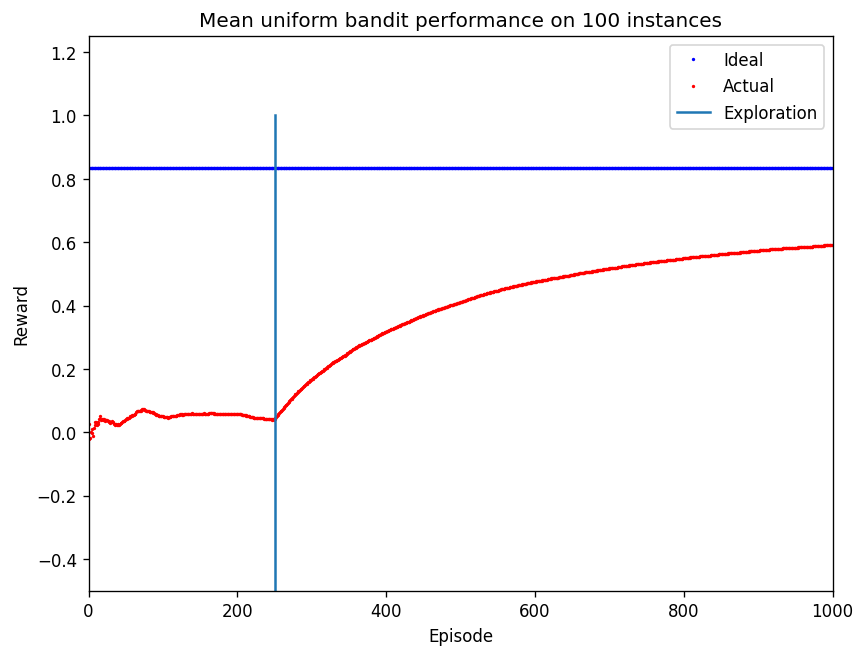

In [101]:
# Plot the results:
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, instance.total_plays)

# Plot the
p1 = ax.plot(
    accumulated_history_of_ideal_mean_rewards_greedy / instances, "bo", markersize=1
)
p2 = ax.plot(accumulated_history_of_mean_rewards_greedy / instances, "ro", markersize=1)

# Plot a vertical line to indicate the cut off between exploration and exploitation
ax.plot(
    [uniform_bandit.exploration_episodes, uniform_bandit.exploration_episodes],
    [-0.5, 1],
)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend(["Ideal", "Actual", "Exploration"])

plt.title(f"Mean uniform bandit performance on {instances} instances")

plt.plot()

### Exercise: Implement, test and compare the $\epsilon$-Greedy action selection

Implement $\epsilon$-Greedy action selection below.

In [102]:
class EpsilonGreedyAlgorithm:
    def __init__(self, k_armed_bandit, epsilon):
        self.epsilon = epsilon
        self.k_armed_bandit = k_armed_bandit
        self.best_arm = None

    def run(self, episodes):
        """Run the algorithm for a given number of episodes"""
        assert (
            self.best_arm == None
        ), "You should not call run() twice on the same instance, instead create a new instance"
        assert (
            self.k_armed_bandit.total_plays == 0
        ), "You should not run an algorithm on the same instance twice, instead create a new instance"

        self.best_arm = np.random.randint(0, len(self.k_armed_bandit))

        for _ in range(0, episodes):
            rand_num = np.random.rand()

            # Play a random arm with probability epsilon
            if rand_num < self.epsilon:
                self.k_armed_bandit.play(np.random.randint(0, len(self.k_armed_bandit)))
            else:
                self.k_armed_bandit.play(self.best_arm)

            # Find the index of the arm that yielded the highest mean payout
            self.best_arm = np.argmax(self.k_armed_bandit.observed_means)

Test your implementation, first on one instance and then on multiple instances

Estimated best arm: 2, true best arm 2


[]

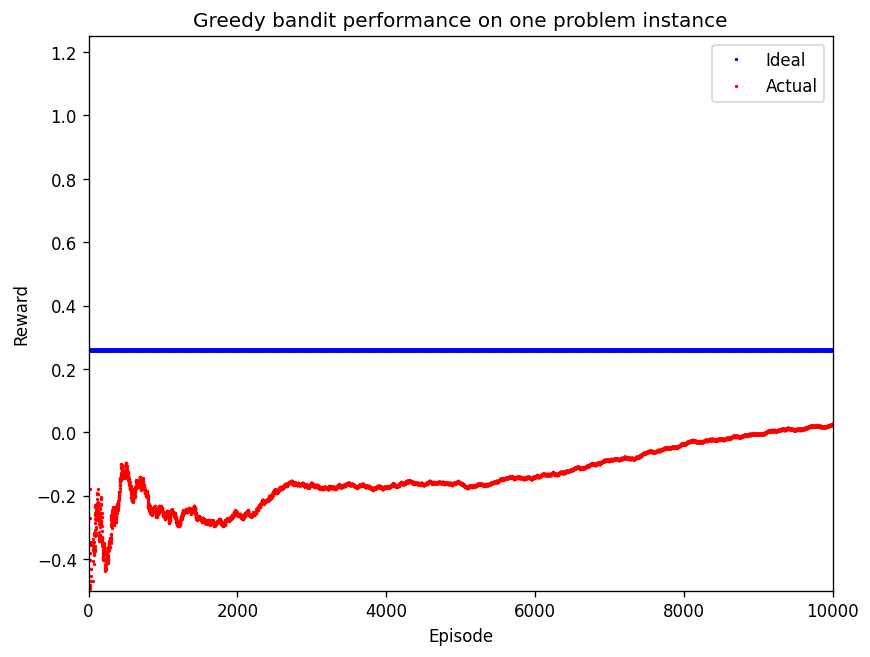

In [103]:
# Generate an instance with 10 arms, means from [-1,1] and a variance of 1
means, variances = kArmedBandit.generate_instance(10, -1, 1, 3)
problem_instance = kArmedBandit(means, variances)

# Create an epsilon greedy algorithm for the problem instance with epsilon=0.1
greedy_bandit = EpsilonGreedyAlgorithm(problem_instance, 0.01)
greedy_bandit.run(10000)

print(
    f"Estimated best arm: {greedy_bandit.best_arm}, "
    f"true best arm {np.argmax(problem_instance.true_means)}"
)

fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, problem_instance.total_plays)

# Plot the
p1 = ax.plot(problem_instance.history_of_ideal_mean_rewards, "bo", markersize=1)
p2 = ax.plot(problem_instance.history_of_mean_rewards, "ro", markersize=1)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend(["Ideal", "Actual"])

plt.title("Greedy bandit performance on one problem instance")

plt.plot()

Try to compare the performance of your $\epsilon$-greedy implementation with the uniform bandit algorithm


Times best arm for greedy found: 82/100
Times best arm for uniform found: 67/100


[]

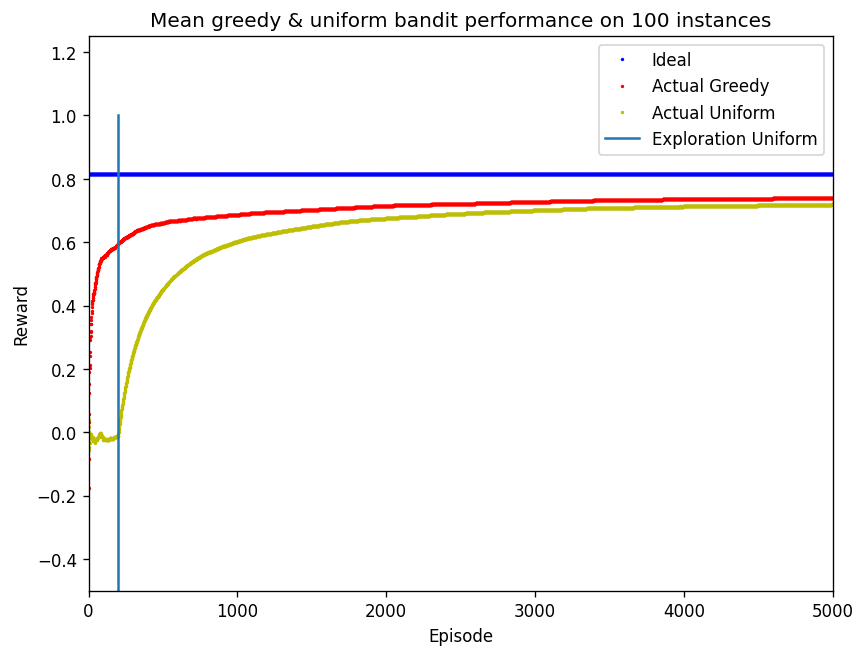

In [104]:
# Config:
instances = 100
arms = 10
episodes = 5000

w = 20
epsilon = 0.05

# Accumulate results across instances data for plotting:
accumulated_history_of_mean_rewards_greedy = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_greedy = np.zeros(episodes)

accumulated_history_of_mean_rewards_uniform = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_uniform = np.zeros(episodes)

greedy_bandit = None
times_best_arm_found_greedy = 0
uniform_bandit = None
times_best_arm_found_uniform = 0

# Create and run instances:
for i in range(0, instances):
    means, variances = kArmedBandit.generate_instance(arms, -1, 1, 1)

    instance_greedy = kArmedBandit(means, variances)
    instance_uniform = kArmedBandit(means, variances)

    greedy_bandit = EpsilonGreedyAlgorithm(instance_greedy, epsilon)
    greedy_bandit.run(episodes)

    accumulated_history_of_ideal_mean_rewards_greedy = (
        accumulated_history_of_ideal_mean_rewards_greedy
        + instance_greedy.history_of_ideal_mean_rewards
    )
    accumulated_history_of_mean_rewards_greedy = (
        accumulated_history_of_mean_rewards_greedy
        + instance_greedy.history_of_mean_rewards
    )

    if greedy_bandit.best_arm == np.argmax(instance_greedy.true_means):
        times_best_arm_found_greedy += 1

    uniform_bandit = UniformBanditAlgorithm(instance_uniform, w)
    uniform_bandit.run(episodes)

    accumulated_history_of_ideal_mean_rewards_uniform = (
        accumulated_history_of_ideal_mean_rewards_uniform
        + instance_uniform.history_of_ideal_mean_rewards
    )
    accumulated_history_of_mean_rewards_uniform = (
        accumulated_history_of_mean_rewards_uniform
        + instance_uniform.history_of_mean_rewards
    )

    if uniform_bandit.best_arm == np.argmax(instance_uniform.true_means):
        times_best_arm_found_uniform += 1

print(f"Times best arm for greedy found: {times_best_arm_found_greedy}/{instances}")
print(f"Times best arm for uniform found: {times_best_arm_found_uniform}/{instances}")

# Plot the results:
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, instance_greedy.total_plays)

# Plot the
ax.plot(
    accumulated_history_of_ideal_mean_rewards_greedy / instances, "bo", markersize=1
)
ax.plot(accumulated_history_of_mean_rewards_greedy / instances, "ro", markersize=1)
ax.plot(accumulated_history_of_mean_rewards_uniform / instances, "yo", markersize=1)

# Plot a vertical line to indicate the cut off between exploration and exploitation
ax.plot(
    [uniform_bandit.exploration_episodes, uniform_bandit.exploration_episodes],
    [-0.5, 1],
)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend(["Ideal", "Actual Greedy", "Actual Uniform", "Exploration Uniform"])

plt.title(f"Mean greedy & uniform bandit performance on {instances} instances")

plt.plot()

### Exercise: Implement, test and compare the Upper Confidence Bound (UCB) algorithm


In [105]:
# Implement, test and compare an upper confidence bound algorithm with the
# other algorithms implemented in this notebook
class UpperConfidenceBound:
    def __init__(self, k_armed_bandit, c):
        self.k_armed_bandit = k_armed_bandit
        self.best_arm = None
        # Exploration parameter
        self.c = c

    def run(self, episodes):
        """Run the Upper Confidence Bound algorithm for a given number of episodes"""
        ucb = np.zeros(len(self.k_armed_bandit))
        for arm in range(0, len(self.k_armed_bandit)):
            # Initialize the algorithm by playing each arm once
            self.k_armed_bandit.play(arm)

        for _ in range(0, episodes - len(self.k_armed_bandit)):
            # Calculate the UCB for each arm
            for arm in range(0, len(self.k_armed_bandit)):
                ucb[arm] = self.k_armed_bandit.observed_means[arm] + self.c * np.sqrt(
                    2
                    * np.log(self.k_armed_bandit.total_plays)
                    / self.k_armed_bandit.number_of_plays[arm]
                )

            # Run the arm with the highest UCB
            self.k_armed_bandit.play(np.argmax(ucb))

            # Find the index of the arm that yielded the highest mean payout
            self.best_arm = np.argmax(self.k_armed_bandit.observed_means)

Estimated best arm: 8, true best arm 9


[]

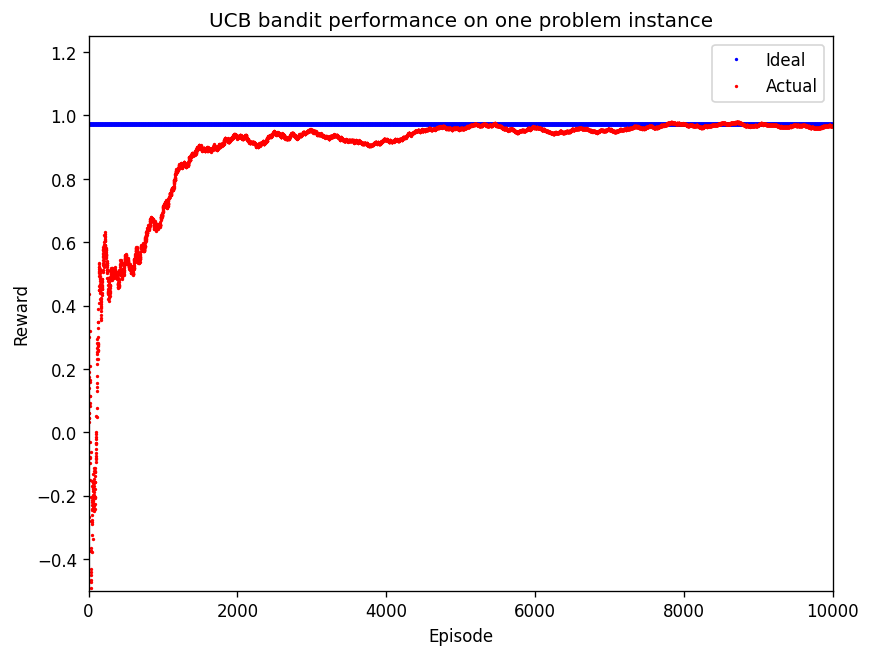

In [106]:
# Generate an instance with 10 arms, means from [-1,1] and a variance of 1
means, variances = kArmedBandit.generate_instance(10, -1, 1, 3)
problem_instance = kArmedBandit(means, variances)

# Create an epsilon greedy algorithm for the problem instance with epsilon=0.1
ucb = UpperConfidenceBound(problem_instance, 2)
ucb.run(10000)

print(
    f"Estimated best arm: {ucb.best_arm}, "
    f"true best arm {np.argmax(problem_instance.true_means)}"
)

fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, problem_instance.total_plays)

# Plot the
p1 = ax.plot(problem_instance.history_of_ideal_mean_rewards, "bo", markersize=1)
p2 = ax.plot(problem_instance.history_of_mean_rewards, "ro", markersize=1)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend(["Ideal", "Actual"])

plt.title("UCB bandit performance on one problem instance")

plt.plot()

# UpperConfidenceBound


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.59it/s]


[]

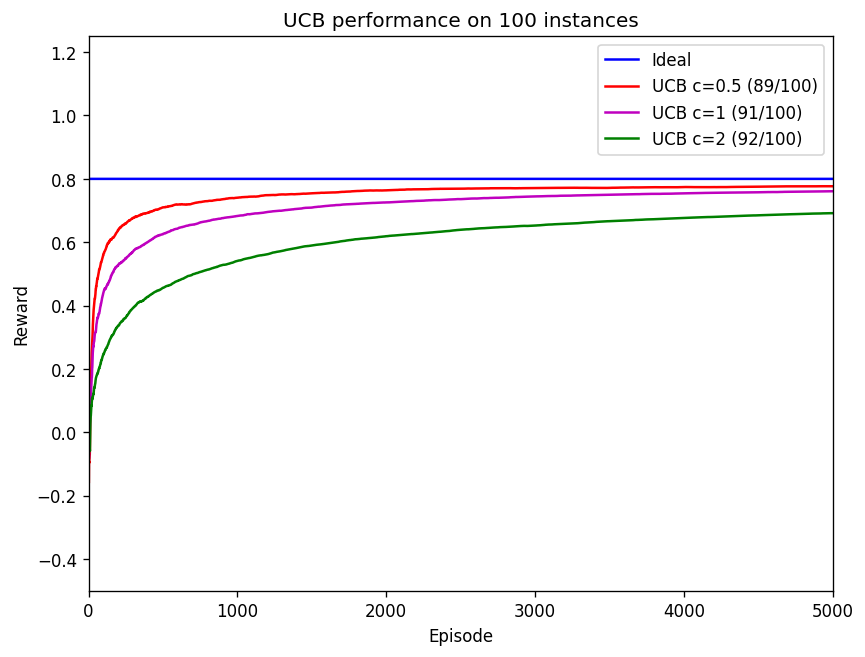

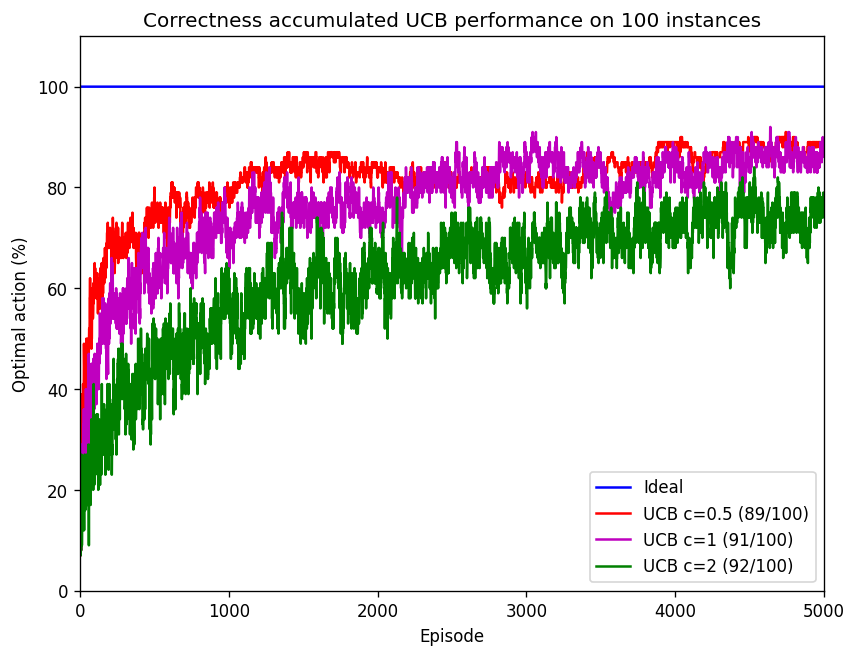

In [107]:
# Make a comparison between the algorithms using procents of times the best arm was found
# Config:
instances = 100
arms = 10
episodes = 5000
c_05 = 0.5
c_1 = 1
c_2 = 2

accumulated_history_of_mean_rewards_ucb_05 = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_ucb_05 = np.zeros(episodes)
accumulated_history_of_correct_best_arm_ucb_05 = np.zeros(episodes)

accumulated_history_of_mean_rewards_ucb_1 = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_ucb_1 = np.zeros(episodes)
accumulated_history_of_correct_best_arm_ucb_1 = np.zeros(episodes)

accumulated_history_of_mean_rewards_ucb_2 = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_ucb_2 = np.zeros(episodes)
accumulated_history_of_correct_best_arm_ucb_2 = np.zeros(episodes)

ucb_bandit_05 = None
times_best_arm_found_ucb_05 = 0
ucb_bandit_1 = None
times_best_arm_found_ucb_1 = 0
ucb_bandit_2 = None
times_best_arm_found_ucb_2 = 0

# Create and run instances:
for i in tqdm(range(0, instances)):
    means, variances = kArmedBandit.generate_instance(arms, -1, 1, 1)

    instance_ucb_05 = kArmedBandit(means, variances)
    instance_ucb_1 = kArmedBandit(means, variances)
    instance_ucb_2 = kArmedBandit(means, variances)

    ucb_bandit_05 = UpperConfidenceBound(instance_ucb_05, c_05)
    ucb_bandit_05.run(episodes)

    accumulated_history_of_ideal_mean_rewards_ucb_05 = (
        accumulated_history_of_ideal_mean_rewards_ucb_05
        + instance_ucb_05.history_of_ideal_mean_rewards
    )
    accumulated_history_of_mean_rewards_ucb_05 = (
        accumulated_history_of_mean_rewards_ucb_05
        + instance_ucb_05.history_of_mean_rewards
    )
    accumulated_history_of_correct_best_arm_ucb_05 = (
        accumulated_history_of_correct_best_arm_ucb_05
        + (
            np.array(instance_ucb_05.history_of_plays)
            == np.argmax(instance_ucb_05.true_means)
        )
    )

    if ucb_bandit_05.best_arm == np.argmax(instance_ucb_05.true_means):
        times_best_arm_found_ucb_05 += 1

    ###
    ucb_bandit_1 = UpperConfidenceBound(instance_ucb_1, c_1)
    ucb_bandit_1.run(episodes)

    accumulated_history_of_ideal_mean_rewards_ucb_1 = (
        accumulated_history_of_ideal_mean_rewards_ucb_1
        + instance_ucb_1.history_of_ideal_mean_rewards
    )
    accumulated_history_of_mean_rewards_ucb_1 = (
        accumulated_history_of_mean_rewards_ucb_1
        + instance_ucb_1.history_of_mean_rewards
    )
    accumulated_history_of_correct_best_arm_ucb_1 = (
        accumulated_history_of_correct_best_arm_ucb_1
        + (
            np.array(instance_ucb_1.history_of_plays)
            == np.argmax(instance_ucb_1.true_means)
        )
    )

    if ucb_bandit_1.best_arm == np.argmax(instance_ucb_1.true_means):
        times_best_arm_found_ucb_1 += 1

    ###
    ucb_bandit_2 = UpperConfidenceBound(instance_ucb_2, c_2)
    ucb_bandit_2.run(episodes)

    accumulated_history_of_ideal_mean_rewards_ucb_2 = (
        accumulated_history_of_ideal_mean_rewards_ucb_2
        + instance_ucb_2.history_of_ideal_mean_rewards
    )
    accumulated_history_of_mean_rewards_ucb_2 = (
        accumulated_history_of_mean_rewards_ucb_2
        + instance_ucb_2.history_of_mean_rewards
    )
    accumulated_history_of_correct_best_arm_ucb_2 = (
        accumulated_history_of_correct_best_arm_ucb_2
        + (
            np.array(instance_ucb_2.history_of_plays)
            == np.argmax(instance_ucb_2.true_means)
        )
    )

    if ucb_bandit_2.best_arm == np.argmax(instance_ucb_2.true_means):
        times_best_arm_found_ucb_2 += 1

# ------------------------------------------------------------------------------#
# Plot the rewards compared to the
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, episodes)

# Plot the
ax.plot(accumulated_history_of_ideal_mean_rewards_ucb_05 / instances, "b", markersize=1)
ax.plot(accumulated_history_of_mean_rewards_ucb_05 / instances, "r", markersize=1)
ax.plot(accumulated_history_of_mean_rewards_ucb_1 / instances, "m", markersize=1)
ax.plot(accumulated_history_of_mean_rewards_ucb_2 / instances, "g", markersize=1)


plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend(
    [
        "Ideal",
        f"UCB c=0.5 ({times_best_arm_found_ucb_05}/{instances})",
        f"UCB c=1 ({times_best_arm_found_ucb_1}/{instances})",
        f"UCB c=2 ({times_best_arm_found_ucb_2}/{instances})",
    ]
)

plt.title(f"UCB performance on {instances} instances")

plt.plot()

# ------------------------------------------------------------------------------#
# # Make a comparison between the algorithms using procents of times the best arm was found
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(0, 110)
plt.xlim(0, episodes)

# Plot the
ax.plot(np.ones(episodes) * 100, "b", markersize=1)
ax.plot(
    accumulated_history_of_correct_best_arm_ucb_05 / instances * 100, "r", markersize=1
)
ax.plot(
    accumulated_history_of_correct_best_arm_ucb_1 / instances * 100, "m", markersize=1
)
ax.plot(
    accumulated_history_of_correct_best_arm_ucb_2 / instances * 100, "g", markersize=1
)


plt.xlabel("Episode")
plt.ylabel("Optimal action (%)")
plt.legend(
    [
        "Ideal",
        f"UCB c=0.5 ({times_best_arm_found_ucb_05}/{instances})",
        f"UCB c=1 ({times_best_arm_found_ucb_1}/{instances})",
        f"UCB c=2 ({times_best_arm_found_ucb_2}/{instances})",
    ]
)

plt.title(f"Correctness accumulated UCB performance on {instances} instances")
plt.plot()

# Greedy

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.12it/s]


[]

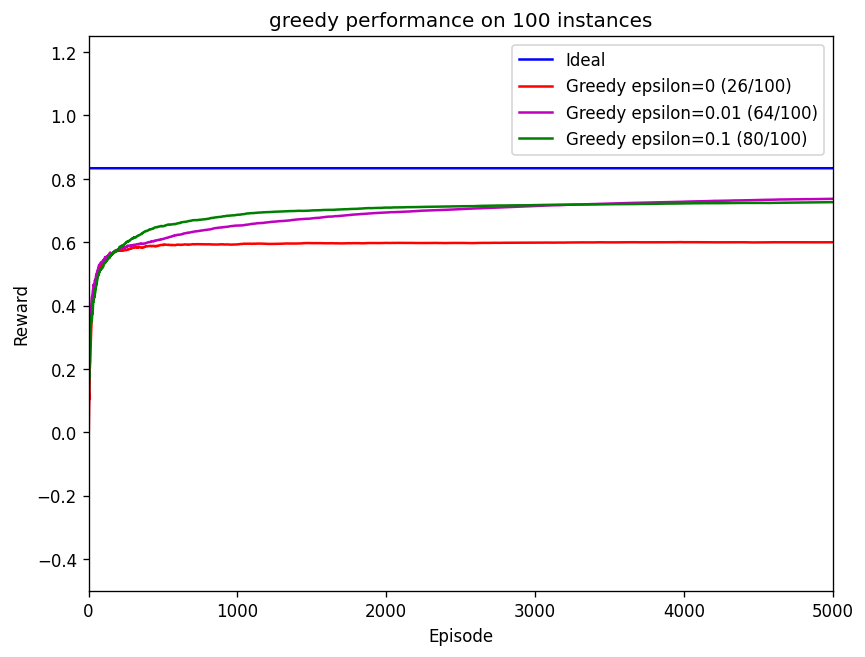

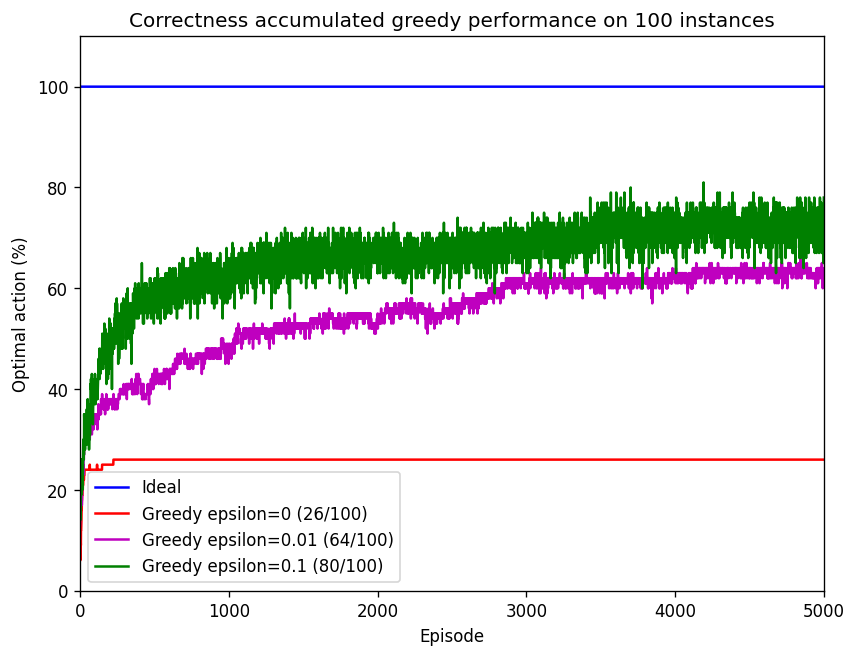

In [108]:
# Config:
instances = 100
arms = 10
episodes = 5000
epsilon_0 = 0
epsilon_001 = 0.01
epsilon_01 = 0.1

accumulated_history_of_mean_rewards_greedy_0 = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_greedy_0 = np.zeros(episodes)
accumulated_history_of_correct_best_arm_greedy_0 = np.zeros(episodes)

accumulated_history_of_mean_rewards_greedy_001 = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_greedy_001 = np.zeros(episodes)
accumulated_history_of_correct_best_arm_greedy_001 = np.zeros(episodes)

accumulated_history_of_mean_rewards_greedy_01 = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_greedy_01 = np.zeros(episodes)
accumulated_history_of_correct_best_arm_greedy_01 = np.zeros(episodes)

greedy_bandit_0 = None
times_best_arm_found_greedy_0 = 0
greedy_bandit_001 = None
times_best_arm_found_greedy_001 = 0
greedy_bandit_01 = None
times_best_arm_found_greedy_01 = 0

# Create and run instances:
for i in tqdm(range(0, instances)):
    means, variances = kArmedBandit.generate_instance(arms, -1, 1, 1)

    instance_greedy_0 = kArmedBandit(means, variances)
    instance_greedy_001 = kArmedBandit(means, variances)
    instance_greedy_01 = kArmedBandit(means, variances)

    greedy_bandit_0 = EpsilonGreedyAlgorithm(instance_greedy_0, epsilon_0)
    greedy_bandit_0.run(episodes)

    accumulated_history_of_ideal_mean_rewards_greedy_0 = (
        accumulated_history_of_ideal_mean_rewards_greedy_0
        + instance_greedy_0.history_of_ideal_mean_rewards
    )
    accumulated_history_of_mean_rewards_greedy_0 = (
        accumulated_history_of_mean_rewards_greedy_0
        + instance_greedy_0.history_of_mean_rewards
    )
    accumulated_history_of_correct_best_arm_greedy_0 = (
        accumulated_history_of_correct_best_arm_greedy_0
        + (
            np.array(instance_greedy_0.history_of_plays)
            == np.argmax(instance_greedy_0.true_means)
        )
    )

    if greedy_bandit_0.best_arm == np.argmax(instance_greedy_0.true_means):
        times_best_arm_found_greedy_0 += 1

    ###
    greedy_bandit_001 = EpsilonGreedyAlgorithm(instance_greedy_001, epsilon_001)
    greedy_bandit_001.run(episodes)

    accumulated_history_of_ideal_mean_rewards_greedy_001 = (
        accumulated_history_of_ideal_mean_rewards_greedy_001
        + instance_greedy_001.history_of_ideal_mean_rewards
    )
    accumulated_history_of_mean_rewards_greedy_001 = (
        accumulated_history_of_mean_rewards_greedy_001
        + instance_greedy_001.history_of_mean_rewards
    )
    accumulated_history_of_correct_best_arm_greedy_001 = (
        accumulated_history_of_correct_best_arm_greedy_001
        + (
            np.array(instance_greedy_001.history_of_plays)
            == np.argmax(instance_greedy_001.true_means)
        )
    )

    if greedy_bandit_001.best_arm == np.argmax(instance_greedy_001.true_means):
        times_best_arm_found_greedy_001 += 1

    ###
    greedy_bandit_01 = EpsilonGreedyAlgorithm(instance_greedy_01, epsilon_01)
    greedy_bandit_01.run(episodes)

    accumulated_history_of_ideal_mean_rewards_greedy_01 = (
        accumulated_history_of_ideal_mean_rewards_greedy_01
        + instance_greedy_01.history_of_ideal_mean_rewards
    )
    accumulated_history_of_mean_rewards_greedy_01 = (
        accumulated_history_of_mean_rewards_greedy_01
        + instance_greedy_01.history_of_mean_rewards
    )
    accumulated_history_of_correct_best_arm_greedy_01 = (
        accumulated_history_of_correct_best_arm_greedy_01
        + (
            np.array(instance_greedy_01.history_of_plays)
            == np.argmax(instance_greedy_01.true_means)
        )
    )

    if greedy_bandit_01.best_arm == np.argmax(instance_greedy_01.true_means):
        times_best_arm_found_greedy_01 += 1

# ------------------------------------------------------------------------------#
# Plot the rewards compared to the
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, episodes)

# Plot the
ax.plot(
    accumulated_history_of_ideal_mean_rewards_greedy_0 / instances, "b", markersize=1
)
ax.plot(accumulated_history_of_mean_rewards_greedy_0 / instances, "r", markersize=1)
ax.plot(accumulated_history_of_mean_rewards_greedy_001 / instances, "m", markersize=1)
ax.plot(accumulated_history_of_mean_rewards_greedy_01 / instances, "g", markersize=1)


plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend(
    [
        "Ideal",
        f"Greedy epsilon=0 ({times_best_arm_found_greedy_0}/{instances})",
        f"Greedy epsilon=0.01 ({times_best_arm_found_greedy_001}/{instances})",
        f"Greedy epsilon=0.1 ({times_best_arm_found_greedy_01}/{instances})",
    ]
)

plt.title(f"greedy performance on {instances} instances")

plt.plot()

# ------------------------------------------------------------------------------#
# # Make a comparison between the algorithms using procents of times the best arm was found
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(0, 110)
plt.xlim(0, episodes)

# Plot the
ax.plot(np.ones(episodes) * 100, "b", markersize=1)
ax.plot(
    accumulated_history_of_correct_best_arm_greedy_0 / instances * 100,
    "r",
    markersize=1,
)
ax.plot(
    accumulated_history_of_correct_best_arm_greedy_001 / instances * 100,
    "m",
    markersize=1,
)
ax.plot(
    accumulated_history_of_correct_best_arm_greedy_01 / instances * 100,
    "g",
    markersize=1,
)


plt.xlabel("Episode")
plt.ylabel("Optimal action (%)")
plt.legend(
    [
        "Ideal",
        f"Greedy epsilon=0 ({times_best_arm_found_greedy_0}/{instances})",
        f"Greedy epsilon=0.01 ({times_best_arm_found_greedy_001}/{instances})",
        f"Greedy epsilon=0.1 ({times_best_arm_found_greedy_01}/{instances})",
    ]
)

plt.title(f"Correctness accumulated greedy performance on {instances} instances")
plt.plot()

# UniformBanditAlgorithm


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.57it/s]


[]

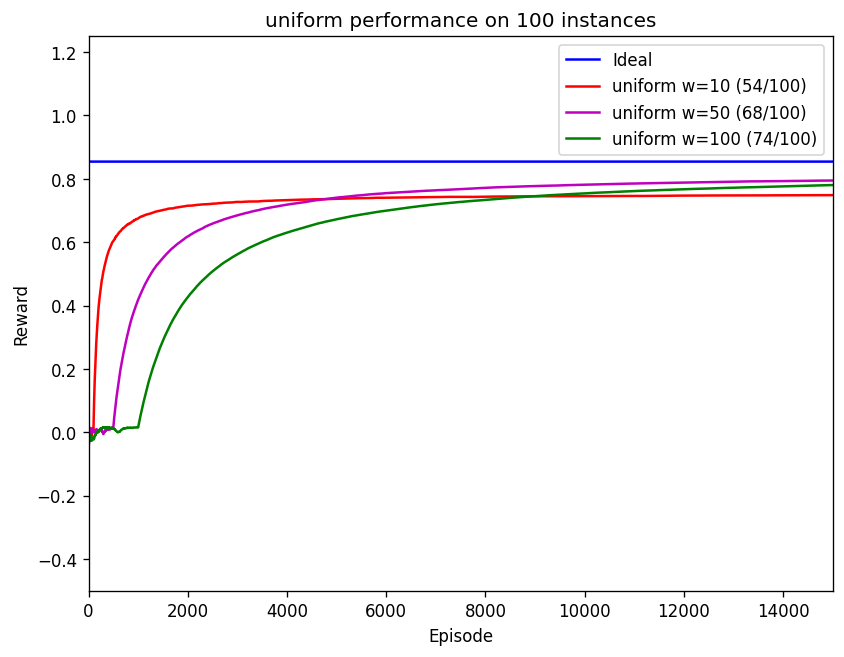

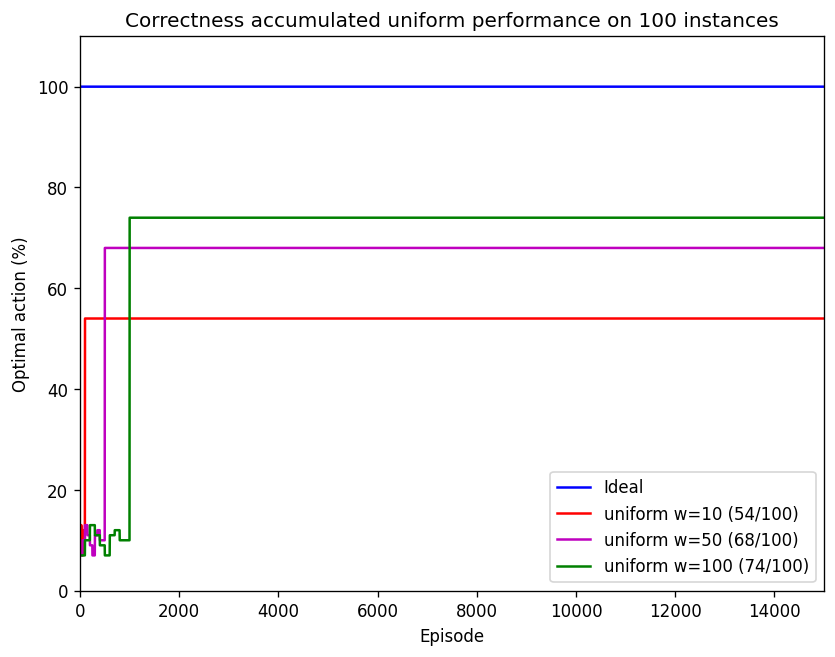

In [109]:
# Config:
instances = 100
arms = 10
episodes = 15000
w_10 = 10
w_50 = 50
w_100 = 100

accumulated_history_of_mean_rewards_uniform_10 = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_uniform_10 = np.zeros(episodes)
accumulated_history_of_correct_best_arm_uniform_10 = np.zeros(episodes)

accumulated_history_of_mean_rewards_uniform_50 = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_uniform_50 = np.zeros(episodes)
accumulated_history_of_correct_best_arm_uniform_50 = np.zeros(episodes)

accumulated_history_of_mean_rewards_uniform_100 = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_uniform_100 = np.zeros(episodes)
accumulated_history_of_correct_best_arm_uniform_100 = np.zeros(episodes)

uniform_bandit_10 = None
times_best_arm_found_uniform_10 = 0
uniform_bandit_50 = None
times_best_arm_found_uniform_50 = 0
uniform_bandit_100 = None
times_best_arm_found_uniform_100 = 0

# Create and run instances:
for i in tqdm(range(0, instances)):
    means, variances = kArmedBandit.generate_instance(arms, -1, 1, 1)

    instance_uniform_10 = kArmedBandit(means, variances)
    instance_uniform_50 = kArmedBandit(means, variances)
    instance_uniform_100 = kArmedBandit(means, variances)

    uniform_bandit_10 = UniformBanditAlgorithm(instance_uniform_10, w_10)
    uniform_bandit_10.run(episodes)

    accumulated_history_of_ideal_mean_rewards_uniform_10 = (
        accumulated_history_of_ideal_mean_rewards_uniform_10
        + instance_uniform_10.history_of_ideal_mean_rewards
    )
    accumulated_history_of_mean_rewards_uniform_10 = (
        accumulated_history_of_mean_rewards_uniform_10
        + instance_uniform_10.history_of_mean_rewards
    )
    accumulated_history_of_correct_best_arm_uniform_10 = (
        accumulated_history_of_correct_best_arm_uniform_10
        + (
            np.array(instance_uniform_10.history_of_plays)
            == np.argmax(instance_uniform_10.true_means)
        )
    )

    if uniform_bandit_10.best_arm == np.argmax(instance_uniform_10.true_means):
        times_best_arm_found_uniform_10 += 1

    ###
    uniform_bandit_50 = UniformBanditAlgorithm(instance_uniform_50, w_50)
    uniform_bandit_50.run(episodes)

    accumulated_history_of_ideal_mean_rewards_uniform_50 = (
        accumulated_history_of_ideal_mean_rewards_uniform_50
        + instance_uniform_50.history_of_ideal_mean_rewards
    )
    accumulated_history_of_mean_rewards_uniform_50 = (
        accumulated_history_of_mean_rewards_uniform_50
        + instance_uniform_50.history_of_mean_rewards
    )
    accumulated_history_of_correct_best_arm_uniform_50 = (
        accumulated_history_of_correct_best_arm_uniform_50
        + (
            np.array(instance_uniform_50.history_of_plays)
            == np.argmax(instance_uniform_50.true_means)
        )
    )

    if uniform_bandit_50.best_arm == np.argmax(instance_uniform_50.true_means):
        times_best_arm_found_uniform_50 += 1

    ###
    uniform_bandit_100 = UniformBanditAlgorithm(instance_uniform_100, w_100)
    uniform_bandit_100.run(episodes)

    accumulated_history_of_ideal_mean_rewards_uniform_100 = (
        accumulated_history_of_ideal_mean_rewards_uniform_100
        + instance_uniform_100.history_of_ideal_mean_rewards
    )
    accumulated_history_of_mean_rewards_uniform_100 = (
        accumulated_history_of_mean_rewards_uniform_100
        + instance_uniform_100.history_of_mean_rewards
    )
    accumulated_history_of_correct_best_arm_uniform_100 = (
        accumulated_history_of_correct_best_arm_uniform_100
        + (
            np.array(instance_uniform_100.history_of_plays)
            == np.argmax(instance_uniform_100.true_means)
        )
    )

    if uniform_bandit_100.best_arm == np.argmax(instance_uniform_100.true_means):
        times_best_arm_found_uniform_100 += 1

# ------------------------------------------------------------------------------#
# Plot the rewards compared to the
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, episodes)

# Plot the
ax.plot(
    accumulated_history_of_ideal_mean_rewards_uniform_10 / instances, "b", markersize=1
)
ax.plot(accumulated_history_of_mean_rewards_uniform_10 / instances, "r", markersize=1)
ax.plot(accumulated_history_of_mean_rewards_uniform_50 / instances, "m", markersize=1)
ax.plot(accumulated_history_of_mean_rewards_uniform_100 / instances, "g", markersize=1)


plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend(
    [
        "Ideal",
        f"uniform w=10 ({times_best_arm_found_uniform_10}/{instances})",
        f"uniform w=50 ({times_best_arm_found_uniform_50}/{instances})",
        f"uniform w=100 ({times_best_arm_found_uniform_100}/{instances})",
    ]
)

plt.title(f"uniform performance on {instances} instances")

plt.plot()

# ------------------------------------------------------------------------------#
# # Make a comparison between the algorithms using procents of times the best arm was found
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(0, 110)
plt.xlim(0, episodes)

# Plot the
ax.plot(np.ones(episodes) * 100, "b", markersize=1)
ax.plot(
    accumulated_history_of_correct_best_arm_uniform_10 / instances * 100,
    "r",
    markersize=1,
)
ax.plot(
    accumulated_history_of_correct_best_arm_uniform_50 / instances * 100,
    "m",
    markersize=1,
)
ax.plot(
    accumulated_history_of_correct_best_arm_uniform_100 / instances * 100,
    "g",
    markersize=1,
)


plt.xlabel("Episode")
plt.ylabel("Optimal action (%)")
plt.legend(
    [
        "Ideal",
        f"uniform w=10 ({times_best_arm_found_uniform_10}/{instances})",
        f"uniform w=50 ({times_best_arm_found_uniform_50}/{instances})",
        f"uniform w=100 ({times_best_arm_found_uniform_100}/{instances})",
    ]
)

plt.title(f"Correctness accumulated uniform performance on {instances} instances")
plt.plot()

[]

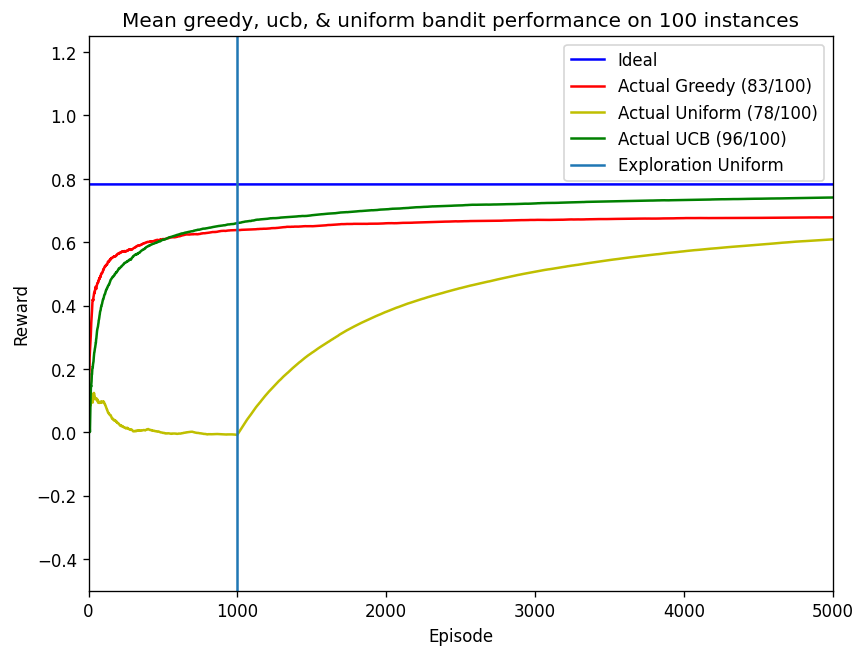

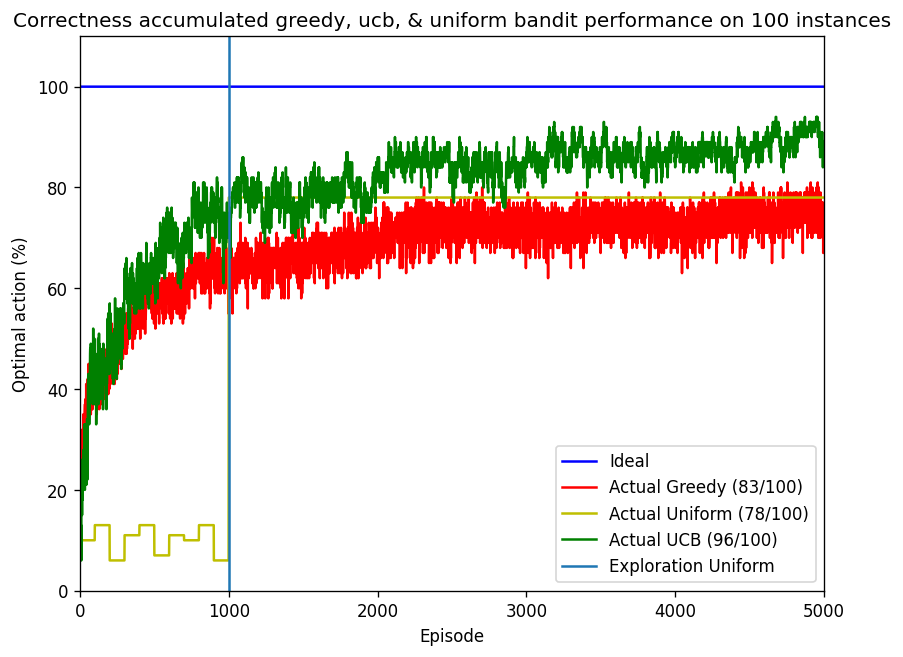

In [110]:
# Make a comparison between the algorithms using procents of times the best arm was found
# Config:
instances = 100
arms = 10
episodes = 5000
w = 100
epsilon = 0.1
c = 1

# Accumulate results across instances data for plotting:
accumulated_history_of_mean_rewards_greedy = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_greedy = np.zeros(episodes)
accumulated_history_of_correct_best_arm_greedy = np.zeros(episodes)

accumulated_history_of_mean_rewards_uniform = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_uniform = np.zeros(episodes)
accumulated_history_of_correct_best_arm_uniform = np.zeros(episodes)

accumulated_history_of_mean_rewards_ucb = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_ucb = np.zeros(episodes)
accumulated_history_of_correct_best_arm_ucb = np.zeros(episodes)

greedy_bandit = None
times_best_arm_found_greedy = 0
uniform_bandit = None
times_best_arm_found_uniform = 0
ucb_bandit = None
times_best_arm_found_ucb = 0

# Create and run instances:
for i in tqdm(range(0, instances)):
    means, variances = kArmedBandit.generate_instance(arms, -1, 1, 1)

    instance_greedy = kArmedBandit(means, variances)
    instance_uniform = kArmedBandit(means, variances)
    instance_ucb = kArmedBandit(means, variances)

    greedy_bandit = EpsilonGreedyAlgorithm(instance_greedy, epsilon)
    greedy_bandit.run(episodes)

    accumulated_history_of_ideal_mean_rewards_greedy = (
        accumulated_history_of_ideal_mean_rewards_greedy
        + instance_greedy.history_of_ideal_mean_rewards
    )
    accumulated_history_of_mean_rewards_greedy = (
        accumulated_history_of_mean_rewards_greedy
        + instance_greedy.history_of_mean_rewards
    )
    accumulated_history_of_correct_best_arm_greedy = (
        accumulated_history_of_correct_best_arm_greedy
        + (
            np.array(instance_greedy.history_of_plays)
            == np.argmax(instance_greedy.true_means)
        )
    )

    if greedy_bandit.best_arm == np.argmax(instance_greedy.true_means):
        times_best_arm_found_greedy += 1

    uniform_bandit = UniformBanditAlgorithm(instance_uniform, w)
    uniform_bandit.run(episodes)

    accumulated_history_of_ideal_mean_rewards_uniform = (
        accumulated_history_of_ideal_mean_rewards_uniform
        + instance_uniform.history_of_ideal_mean_rewards
    )
    accumulated_history_of_mean_rewards_uniform = (
        accumulated_history_of_mean_rewards_uniform
        + instance_uniform.history_of_mean_rewards
    )
    accumulated_history_of_correct_best_arm_uniform = (
        accumulated_history_of_correct_best_arm_uniform
        + (
            np.array(instance_uniform.history_of_plays)
            == np.argmax(instance_uniform.true_means)
        )
    )

    if uniform_bandit.best_arm == np.argmax(instance_uniform.true_means):
        times_best_arm_found_uniform += 1

    ucb_bandit = UpperConfidenceBound(instance_ucb, c)
    ucb_bandit.run(episodes)

    accumulated_history_of_ideal_mean_rewards_ucb = (
        accumulated_history_of_ideal_mean_rewards_ucb
        + instance_ucb.history_of_ideal_mean_rewards
    )
    accumulated_history_of_mean_rewards_ucb = (
        accumulated_history_of_mean_rewards_ucb + instance_ucb.history_of_mean_rewards
    )
    accumulated_history_of_correct_best_arm_ucb = (
        accumulated_history_of_correct_best_arm_ucb
        + (
            np.array(instance_ucb.history_of_plays)
            == np.argmax(instance_ucb.true_means)
        )
    )

    if ucb_bandit.best_arm == np.argmax(instance_ucb.true_means):
        times_best_arm_found_ucb += 1

# ------------------------------------------------------------------------------#
# Plot the rewards compared to the
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, instance_greedy.total_plays)

# Plot the
ax.plot(accumulated_history_of_ideal_mean_rewards_greedy / instances, "b", markersize=1)
ax.plot(accumulated_history_of_mean_rewards_greedy / instances, "r", markersize=1)
ax.plot(accumulated_history_of_mean_rewards_uniform / instances, "y", markersize=1)
ax.plot(accumulated_history_of_mean_rewards_ucb / instances, "g", markersize=1)

# Plot a vertical line to indicate the cut off between exploration and exploitation
ax.plot(
    [uniform_bandit.exploration_episodes, uniform_bandit.exploration_episodes],
    [-0.5, 1.25],
)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend(
    [
        "Ideal",
        f"Actual Greedy ({times_best_arm_found_greedy}/{instances})",
        f"Actual Uniform ({times_best_arm_found_uniform}/{instances})",
        f"Actual UCB ({times_best_arm_found_ucb}/{instances})",
        "Exploration Uniform",
    ]
)

plt.title(f"Mean greedy, ucb, & uniform bandit performance on {instances} instances")

plt.plot()

# ------------------------------------------------------------------------------#
# # Make a comparison between the algorithms using procents of times the best arm was found
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(0, 110)
plt.xlim(0, instance_greedy.total_plays)

# Plot the
ax.plot(np.ones(episodes) * 100, "b", markersize=1)
ax.plot(
    accumulated_history_of_correct_best_arm_greedy / instances * 100, "r", markersize=1
)
ax.plot(
    accumulated_history_of_correct_best_arm_uniform / instances * 100, "y", markersize=1
)
ax.plot(
    accumulated_history_of_correct_best_arm_ucb / instances * 100, "g", markersize=1
)

# Plot a vertical line to indicate the cut off between exploration and exploitation
ax.plot(
    [uniform_bandit.exploration_episodes, uniform_bandit.exploration_episodes], [0, 110]
)

plt.xlabel("Episode")
plt.ylabel("Optimal action (%)")
plt.legend(
    [
        "Ideal",
        f"Actual Greedy ({times_best_arm_found_greedy}/{instances})",
        f"Actual Uniform ({times_best_arm_found_uniform}/{instances})",
        f"Actual UCB ({times_best_arm_found_ucb}/{instances})",
        "Exploration Uniform",
    ]
)

plt.title(
    f"Correctness accumulated greedy, ucb, & uniform bandit performance on {instances} instances"
)

plt.plot()